In [0]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data

In [0]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
sess = tf.InteractiveSession()
#save_path = "/content/gdrive/My Drive/Colab Notebooks/DeepLearning19/HW2/models/MNIST_L2/mnist_model.ckpt"
#save_rec_path = "/content/gdrive/My Drive/Colab Notebooks/DeepLearning19/HW2/models/MNIST_L2/"

In [0]:
#functions to initialize weight
#add to Ws collection and bs collections for L2 regularization
def weight_variable(shape, lamb=0.001):
    initial = tf.truncated_normal(shape, stddev=0.1)
    tf.add_to_collection('Ws', initial)
    if lamb > 0.0:
        print('L2 regularization activated')
        L2loss = tf.multiply(tf.nn.l2_loss(initial), lamb, name='L2_loss')
        tf.add_to_collection('losses', L2loss)
    return tf.Variable(initial)
def bias_variable(shape):
  initial = tf.constant(0.1, shape = shape)
  tf.add_to_collection('bs', initial)
  return tf.Variable(initial)

#layer function
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding = 'SAME')
def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')

In [0]:
#the placeholders for dataset
with tf.name_scope("feed_data"):
  x = tf.placeholder(tf.float32, shape=[None, 784])
  y_ = tf.placeholder(tf.float32, shape=[None, 10])
  x_image = tf.reshape(x, [-1, 28, 28, 1])

In [0]:
#for HW2 CNN hidden activation visualization
#deep convolution
with tf.name_scope("dconv_layers"):
  conv_struct = [
  [5, 5, 1, 32]
  ]

  Ws = []
  bs = []
  a_s = [x_image]

  for i, sh in enumerate(conv_struct):
    wi = weight_variable(sh)
    bi = bias_variable([sh[3]])
    Ws.append(wi)
    bs.append(bi)
    a_s.append(tf.nn.relu(conv2d(a_s[-1], wi) + bi))
  #print(len(zs))
  h_dconv = a_s[-1]

L2 regularization activated


In [0]:
#maxpool1 + conv2 + maxploo2
with tf.name_scope("conv2"):
  h_pool1 = max_pool_2x2(h_dconv)
  W_conv2 = weight_variable([5, 5, 32, 64])
  b_conv2 = bias_variable([64])
  h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
  h_pool2 = max_pool_2x2(h_conv2)

L2 regularization activated


In [0]:
#fully connected layre 1
with tf.name_scope("fc1"):
  W_fc1 = weight_variable([7 * 7 * 64, 1024])
  b_fc1 = bias_variable([1024])

  h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
  h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)


L2 regularization activated


In [0]:
#dropout layer
with tf.name_scope("dropout"):
  keep_prob = tf.placeholder(tf.float32)
  h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
#fully connected layer 2, output layer
with tf.name_scope("fc2"):
  W_fc2 = weight_variable([1024, 10])
  b_fc2 = bias_variable([10])

  prediction =tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2) #this is the output

L2 regularization activated


In [0]:
#define loss and evaluations:
with tf.name_scope("Losses"):
  cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(prediction), reduction_indices=[1]))
  tf.add_to_collection('losses', cross_entropy)
  total_loss = tf.add_n(tf.get_collection('losses'))
with tf.name_scope("trainer"):
  train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy) 
  train_step_L2 = tf.train.AdamOptimizer(1e-4).minimize(total_loss)######## L2 ##################
with tf.name_scope("statistics"):
  correct_prediction = tf.equal(tf.argmax(prediction,1), tf.argmax(y_,1))
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [0]:
#mount google drive on colab for saving session variables
from google.colab import drive
import os
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
#Model Saving/Loading Config
#adding new folder when reopening is better
saver = tf.train.Saver(max_to_keep=5) #(max_to_keep=3)
save_path = "/content/gdrive/My Drive/Colab Notebooks/DeepLearning19/HW2/models/MNIST_L2/"
LOAD_MODEL = False
SAVE_MODEL = True

if LOAD_MODEL:
  saver.restore(sess, save_path+'mnist_model_l2.ckpt')
  import json
  with open(save_path+'rec.json', 'r') as fo:
    rec = json.load(fo)
else:
  initop = tf.global_variables_initializer()
  sess.run(initop)
  rec = {
  "loss" : [],
  "train" : [],
  "test"  : [],
  "valid" : []
  }
#saver.save(sess, save_path) #test

In [0]:
#hypher params / training setting
n_iteration = 8000 # 
batch_size = 50
test_size = 1000
record_frequency = 100

In [0]:
from tqdm import tqdm
from tqdm import trange
import time
#traning process
#with tqdm trange process bar

with trange(n_iteration) as tqdmrange:
  for i in tqdmrange:
    tqdmrange.set_description('interation {}'.format(i))
    batch = mnist.train.next_batch(batch_size, shuffle=True) #get next training batch
    if i%record_frequency == 0:
      test_batch = mnist.test.next_batch(test_size, shuffle=True)
      valid_batch = mnist.validation.next_batch(test_size, shuffle=True)
      #calculate and append training history
      #becareful to use batch size to validate istead of the whole dataset
      train_CE = cross_entropy.eval(feed_dict={ x:batch[0], y_: batch[1], keep_prob: 1.0})
      train_accuracy = accuracy.eval(feed_dict={ x:batch[0], y_: batch[1], keep_prob: 1.0})
      test_accuracy = accuracy.eval(feed_dict={ x: test_batch[0], y_: test_batch[1], keep_prob : 1.0})
      valid_accuracy = accuracy.eval(feed_dict={ x: valid_batch[0], y_: valid_batch[1], keep_prob : 1.0})
      rec["loss"].append(train_CE)
      rec["train"].append(train_accuracy)
      rec["test"].append(test_accuracy)
      rec["valid"].append(valid_accuracy)
      tqdmrange.set_postfix(loss=train_CE,  train_accuracy=train_accuracy, test_accuracy=test_accuracy)
    train_step_L2.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5}) #L2 reg

#save model
import json
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NpEncoder, self).default(obj)

with open(save_path+"rec_l2.json","w") as fo:
  json.dump(rec, fo, cls=NpEncoder)
saver.save(sess, save_path+'mnist_model_l2.ckpt') 
print("model saved at {}".format(save_path))
print("test accuracy {}".format(accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob : 1.0})))

interation 3999: 100%|██████████| 4000/4000 [12:27<00:00,  6.12it/s, loss=0.00682, test_accuracy=0.989, train_accuracy=1]


model saved at /content/gdrive/My Drive/Colab Notebooks/DeepLearning19/HW2/models/MNIST_L2/
test accuracy 0.9908000230789185


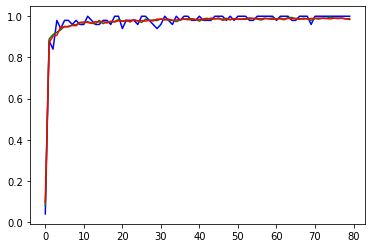

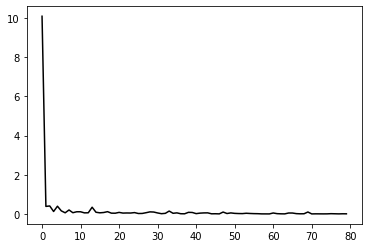

In [0]:
import matplotlib.pyplot as plt

#because there is dropout layer training curve may be weird .
plt.figure()
plt.plot(rec["train"], color="blue")
plt.plot(rec["test"] , color="green")
plt.plot(rec["valid"], color="red")
plt.show()

plt.figure()
plt.plot(rec["loss"], color="black")
plt.show()


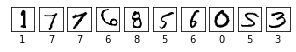

[1, 7, 7, 6, 8, 5, 6, 0, 5, 3]


In [0]:
#show some predictions
import matplotlib.pyplot as plt

n_show = 10

plt.figure(figsize=(5, 5))
for i in range(n_show):
    plt.subplot(1, 10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(mnist.test.images[i].reshape(28,28), cmap=plt.cm.binary)
    plt.xlabel(np.argmax(mnist.test.labels[i]))
plt.show()

print([np.argmax(prediction.eval(feed_dict={x: mnist.test.images[i].reshape(-1,784),keep_prob:1.0})) for i in range(n_show)])

In [0]:
def get_mismatch_ids():
  mismatch_ids = []
  for i in range(mnist.test.labels.shape[0]):
    prediction_i = np.argmax(prediction.eval(feed_dict={x: mnist.test.images[i].reshape(-1,784),keep_prob:1.0}))
    if prediction_i != np.argmax(mnist.test.labels[i]):
      mismatch_ids.append(i)
  return mismatch_ids 

def show_mismatch(mismatch_ids, show_num=10):
  _cnt = 1
  for i in mismatch_ids[:show_num]:
      plt.subplot(1,show_num,_cnt)
      _cnt += 1
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(mnist.test.images[i].reshape(28,28), cmap=plt.cm.binary)
      plt.xlabel(np.argmax(mnist.test.labels[i]))
  plt.show()
  print(mismatch_ids[:show_num])
  print("prediction:")
  print([np.argmax(prediction.eval(feed_dict={x: mnist.test.images[i].reshape(-1,784),keep_prob:1.0})) for i in mismatch_ids[:10]])
  print("label bt human:")
  print([np.argmax(mnist.test.labels[i]) for i in mismatch_ids[:show_num]])

In [0]:
def show_info_by_id(id0 : int, n_show_feature=5):
  print("label : ", np.argmax(mnist.test.labels[id0]))
  pred_id0 = prediction.eval(feed_dict={x: mnist.test.images[id0].reshape(-1,784),keep_prob:1.0})
  mismatch_label =  np.argmax(pred_id0)
  print("prediction : ", mismatch_label)
  print("prediction vector: ", pred_id0)
  hidden1 = h_dconv.eval(feed_dict={x: mnist.test.images[id0].reshape(-1,784),keep_prob:1.0})
  hidden2 = h_conv2.eval(feed_dict={x: mnist.test.images[id0].reshape(-1,784),keep_prob:1.0})

  for i in range(1, 1+n_show_feature ):
    plt.subplot(2,n_show_feature ,i)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    #print(hidden1.shape)
    plt.imshow(hidden1[0, :, :, i].reshape(28,28), cmap=plt.cm.binary)
    #plt.xlabel(np.argmax(mnist.test.labels[id0]))

  for i in range(1, 1+n_show_feature ):
    plt.subplot(2,n_show_feature ,n_show_feature +i)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    #print(hidden2.shape)
    plt.imshow(hidden2[0, :, :, i].reshape(14,14), cmap=plt.cm.binary)
    #plt.xlabel(np.argmax(mnist.test.labels[id0]))

  plt.show()
  return

def find_id_of_correct_pred_of_label(mismatch_label : int):
  for i in range(mnist.test.labels.shape[0]):
    #print("hi")
    if np.argmax(mnist.test.labels[i]) == mismatch_label:
      pred_i = np.argmax(prediction.eval(feed_dict={x: mnist.test.images[i].reshape(-1,784),keep_prob:1.0}))
      if pred_i == mismatch_label:
        print("find example of correct prediction of label {} at id {}".format(mismatch_label, i))
        return i
  return None

4


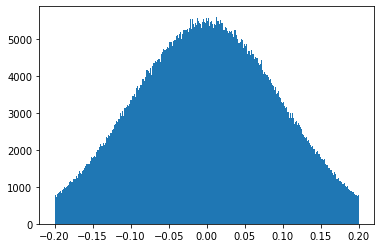

3273504

In [0]:
def show_Ws_hist():
  #from copy import deepcopy
  trained_Ws = tf.get_collection("Ws") #get variables of W
  print(len(trained_Ws))
  trained_Ws = sess.run(trained_Ws) #get val of variables by sess.run()
  Wflat = np.asarray([]) #empty np array
  #use r_ + flatteen to get 1d
  for val in trained_Ws: 
    Wflat = np.r_[Wflat,val.flatten()]
  #print(Wflat.shape)
  #show histogram by plt
  plt.figure()
  plt.hist(Wflat, 1000)
  plt.show()
  return Wflat.shape[0]
show_Ws_hist()

In [0]:
mismatch_ids = get_mismatch_ids()

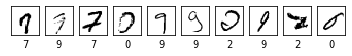

[16, 139, 147, 170, 486, 695, 842, 894, 921, 1152]
prediction:
[9, 7, 2, 7, 7, 5, 0, 1, 7, 8]
label bt human:
[7, 9, 7, 0, 9, 9, 2, 9, 2, 0]


In [0]:
show_mismatch(mismatch_ids, show_num=10)

label :  7
prediction :  2
prediction vector:  [[1.4974161e-06 9.1150177e-05 6.9009131e-01 5.6864675e-03 4.8013785e-06
  3.3949146e-08 2.4415323e-08 3.0396190e-01 1.6090475e-04 1.8186493e-06]]


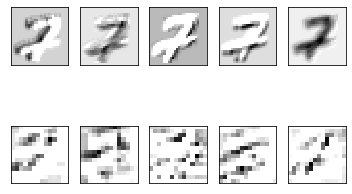

In [0]:
show_info_by_id(mismatch_ids[2], n_show_feature = 5)

find example of correct prediction of label 2 at id 37
label :  2
prediction :  2
prediction vector:  [[4.1387427e-08 1.3237795e-06 9.9999738e-01 7.3762317e-07 2.9132414e-08
  1.0675836e-09 3.2059824e-09 4.8973072e-07 1.3712968e-08 3.5217054e-10]]


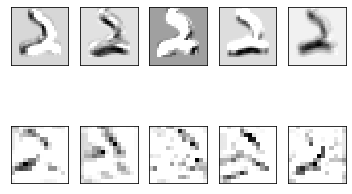

In [0]:
id_example = find_id_of_correct_pred_of_label(2)
show_info_by_id(id_example, n_show_feature = 5)

In [0]:
print(mnist.test.labels[100])
train_CE = cross_entropy.eval(feed_dict={x: mnist.test.images[100].reshape(-1,784), y_:mnist.test.labels[100].reshape(-1,10), keep_prob:1.0})
train_CEL2 = total_loss.eval(feed_dict={x: mnist.test.images[100].reshape(-1,784), y_:mnist.test.labels[100].reshape(-1,10),keep_prob:1.0})
print(train_CE, '\n' ,train_CEL2)

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
9.358367e-05 
 12671.799


In [0]:
train_step_L2.inputs